# Homework 2 - Soccer analytics


### Libraries

In [21]:
import pandas as pd 
import numpy as np 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last"
import json
from pandas.io.json import json_normalize 
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from matplotlib.pyplot import Rectangle
from matplotlib.patches import ConnectionPatch,Arc
from scipy.stats import chi2_contingency

### Importing Data

In [2]:
coaches = pd.read_json(r"C:\Users\gabri\Dropbox\Magistrale Data Science Roma\Algorithmic methods of data mining\Homeworks\Homework 2\Data\coaches.json")
teams = pd.read_json(r"C:\Users\gabri\Dropbox\Magistrale Data Science Roma\Algorithmic methods of data mining\Homeworks\Homework 2\Data\teams.json")
events_england = pd.read_json(r"C:\Users\gabri\Dropbox\Magistrale Data Science Roma\Algorithmic methods of data mining\Homeworks\Homework 2\Data\events\events_England.json")
matches_england = pd.read_json(r"C:\Users\gabri\Dropbox\Magistrale Data Science Roma\Algorithmic methods of data mining\Homeworks\Homework 2\Data\matches\matches_England.json")
players = pd.read_json(r"C:\Users\gabri\Dropbox\Magistrale Data Science Roma\Algorithmic methods of data mining\Homeworks\Homework 2\Data\players.json")



## [RQ1] 
Who wants to be a Champion? During a season could happen that a team has bad periods. For example, more than three consecutive games lost, or it could have a positive trend where it seems to be unbeatable. Let's visualize this trends!

Create a plot where each point (x,y) represents the number of points obtained by team x at game week y. In order to show the trends, points related to the same team must be connected to each other. Remind: in soccer each team gets 3 points for a win, 1 point for a tied game, and 0 for a loss. Highlight the two teams that got the longest winning streak (# of consecutive wins), and the two teams that got the longest losing streak (# of consecutive losses).

Below you can see a similar example of what we would like you to show us. Keep in mind that you must create this plot for all the entire season (38 game weeks).

In [3]:
interestofdata=matches_england[["gameweek","winner","label"]]
interestofdata.head()

,gameweek,winner,label
0,38,1659,"Burnley - AFC Bournemouth, 1 - 2"
1,38,1628,"Crystal Palace - West Bromwich Albion, 2 - 0"
2,38,1609,"Huddersfield Town - Arsenal, 0 - 1"
3,38,1612,"Liverpool - Brighton & Hove Albion, 4 - 0"
4,38,1611,"Manchester United - Watford, 1 - 0"


In [4]:
#Here i just seperate the team name from each other 
x=[]
for i in range(interestofdata.shape[0]):
    x.append([interestofdata["label"].str.split(",")[i][0].split("-")[0],interestofdata["label"].str.split(",")[i][0].split("-")[1]])
x[:10]

[['Burnley ', ' AFC Bournemouth'],
 ['Crystal Palace ', ' West Bromwich Albion'],
 ['Huddersfield Town ', ' Arsenal'],
 ['Liverpool ', ' Brighton & Hove Albion'],
 ['Manchester United ', ' Watford'],
 ['Newcastle United ', ' Chelsea'],
 ['Southampton ', ' Manchester City'],
 ['Swansea City ', ' Stoke City'],
 ['Tottenham Hotspur ', ' Leicester City'],
 ['West Ham United ', ' Everton']]

In [5]:
# New data frame with Home - Away teams seperated
x=pd.DataFrame(x)
x.columns=["team1name","team2name"]
interestofdata=pd.concat([x,interestofdata],axis=1)
interestofdata
interestofdata.drop("label",axis=1,inplace=True)
interestofdata.head()

,team1name,team2name,gameweek,winner
0,Burnley,AFC Bournemouth,38,1659
1,Crystal Palace,West Bromwich Albion,38,1628
2,Huddersfield Town,Arsenal,38,1609
3,Liverpool,Brighton & Hove Albion,38,1612
4,Manchester United,Watford,38,1611


In [6]:
interestofdata.sort_values(by="gameweek",inplace=True)
interestofdata.reset_index(drop=True,inplace=True)
interestofdata.head(10)

,team1name,team2name,gameweek,winner
0,Arsenal,Leicester City,1,1609
1,Manchester United,West Ham United,1,1611
2,Newcastle United,Tottenham Hotspur,1,1624
3,Brighton & Hove Albion,Manchester City,1,1625
4,Chelsea,Burnley,1,1646
5,Watford,Liverpool,1,0
6,Everton,Stoke City,1,1623
7,Southampton,Swansea City,1,0
8,West Bromwich Albion,AFC Bournemouth,1,1627
9,Crystal Palace,Huddersfield Town,1,1673


In [7]:
# matching teams name with their ids by finding it in team datas
holder=[]
for i in range(interestofdata.shape[0]):
    holder.append((teams[teams["name"]==interestofdata.loc[i,"team1name"].rstrip()]["wyId"].values[0],
                  teams[teams["name"]==interestofdata.loc[i,"team2name"].lstrip()]["wyId"].values[0]))
holder[:10]

[(1609, 1631),
 (1611, 1633),
 (1613, 1624),
 (1651, 1625),
 (1610, 1646),
 (1644, 1612),
 (1623, 1639),
 (1619, 10531),
 (1627, 1659),
 (1628, 1673)]

In [8]:
#concat the team id dataset and interest of data
seconddata=pd.concat([pd.DataFrame(holder,columns=["team1code","team2code"]),interestofdata],axis=1)
seconddata.head()

,team1code,team2code,team1name,team2name,gameweek,winner
0,1609,1631,Arsenal,Leicester City,1,1609
1,1611,1633,Manchester United,West Ham United,1,1611
2,1613,1624,Newcastle United,Tottenham Hotspur,1,1624
3,1651,1625,Brighton & Hove Albion,Manchester City,1,1625
4,1610,1646,Chelsea,Burnley,1,1646


In [9]:
# there is a spaces at teamdatas because of splitting them. They are removed here.
seconddata["team2name"]=seconddata["team2name"].str.lstrip()
seconddata["team1name"]=seconddata["team1name"].str.rstrip()

In [10]:
# These code chunks iterate over all data set and it looks for winner column. Datas are stored in order dict
#if it equal 0  it ats both team 1
#if winner is first team it adds 3 points to winner and 0 to its oppenents and vice versa 
teamtotalscores=defaultdict(list)
for i in range(seconddata.shape[0]):
    if seconddata.iloc[i,5] == 0:
        teamtotalscores[seconddata.iloc[i,3]].append(1)
        teamtotalscores[seconddata.iloc[i,2]].append(1)
        
    elif seconddata.iloc[i,0] == seconddata.iloc[i,5]:
        teamtotalscores[seconddata.iloc[i,2]].append(3)
        teamtotalscores[seconddata.iloc[i,3]].append(0)
    elif seconddata.iloc[i,1] == seconddata.iloc[i,5]:
        teamtotalscores[seconddata.iloc[i,3]].append(3)
        teamtotalscores[seconddata.iloc[i,2]].append(0)


In [11]:
#consecutive winner counter
consecutivewin=defaultdict(list)
for keys in teamtotalscores.keys():
    counter = 0
    for values in teamtotalscores[keys]:
        if values == 3:
            counter += 1
        elif values != 3: 
            consecutivewin[keys].append(counter)
            counter=0

In [12]:
for keys in consecutivewin.keys():
    consecutivewin[keys]= max(consecutivewin[keys])

### Two teams that got the longest winning streak 

In [13]:
topconsecutivewin=pd.DataFrame.from_dict(dict(consecutivewin),orient="index").sort_values(by=0,ascending = False)[:2]
topconsecutivewin.rename(columns={0:"#of win"},inplace=True)
topconsecutivewin

,#of win
Manchester City,18
Tottenham Hotspur,7


### Two teams that got the longest losing streak

In [14]:
#consecutive looser counter
consecutiveloser=defaultdict(list)
for keys in teamtotalscores.keys():
    counter = 0
    for values in teamtotalscores[keys]:
        if values == 0:
            counter += 1
        elif values != 0: 
            consecutiveloser[keys].append(counter)
            counter=0
for keys in consecutiveloser.keys():
    consecutiveloser[keys]= max(consecutiveloser[keys])
topconsecutiveloose=pd.DataFrame.from_dict(dict(consecutiveloser),orient="index").sort_values(by=0,ascending = False)[:2]
topconsecutiveloose.rename(columns={0:"#ofloss"},inplace=True)

In [15]:
#cumsum of each team by the weeks
x=pd.DataFrame(teamtotalscores).set_index([["w\n{}".format(i) for i in range(1,39)]],drop=True).cumsum()
x.head()

,Arsenal,Leicester City,Manchester United,West Ham United,Tottenham Hotspur,Newcastle United,Manchester City,Brighton & Hove Albion,Burnley,Chelsea,Liverpool,Watford,Everton,Stoke City,Swansea City,Southampton,West Bromwich Albion,AFC Bournemouth,Huddersfield Town,Crystal Palace
w\n1,3,0,3,0,3,0,3,0,3,0,1,1,3,0,1,1,3,0,3,0
w\n2,3,3,6,0,3,0,4,0,3,3,4,4,4,3,1,4,6,0,6,0
w\n3,3,3,9,0,4,3,7,1,4,6,7,5,4,4,4,5,7,0,7,0
w\n4,6,3,10,3,7,6,10,4,7,9,7,8,4,5,4,5,7,0,7,0
w\n5,7,4,13,4,8,9,13,4,8,10,8,8,4,5,5,8,8,3,8,0


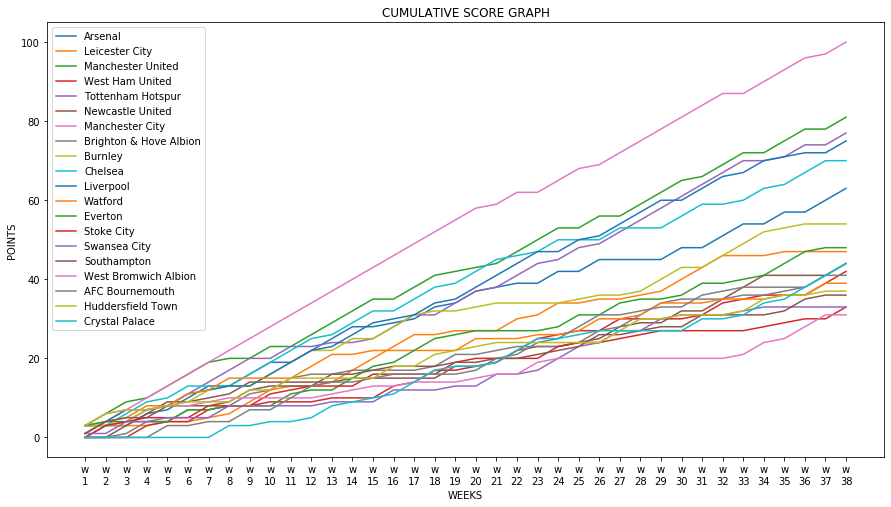

In [16]:
xlabel=pd.Series(x.index)
plt.figure(figsize=[15,8])
plt.subplot(1,1,1)
plt.plot(xlabel,x.values)
plt.xlabel("WEEKS")
plt.ylabel("POINTS")
plt.title("CUMULATIVE SCORE GRAPH")
plt.legend([i for i in x.columns])

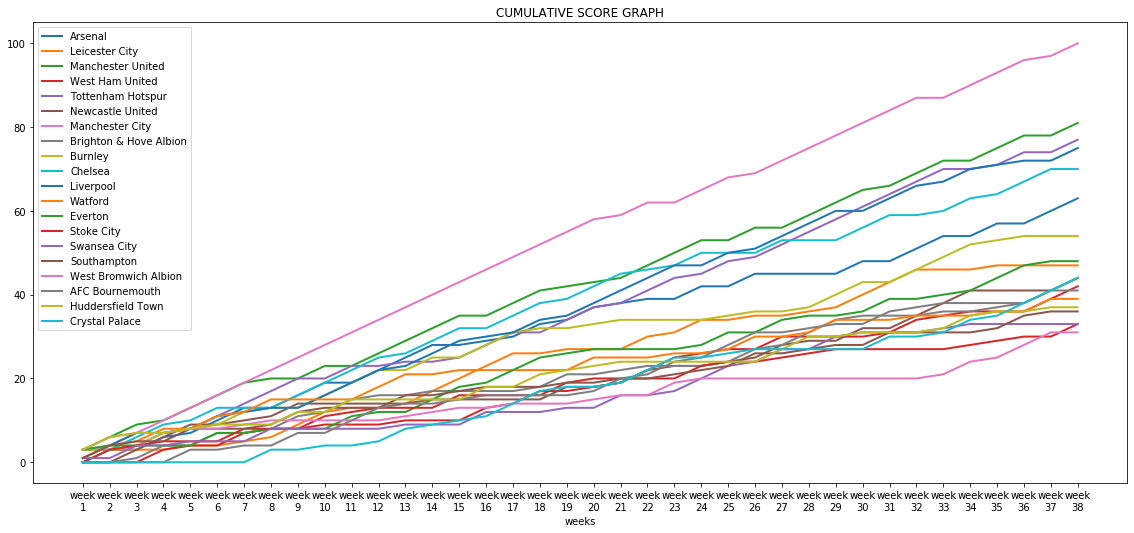

In [17]:
fig = plt.figure(figsize=(19,8))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
y = x.values
ax.plot([i for i in range(0,380,10)], y,linewidth=2)
ax.set_xlabel("weeks")
ax.set_title("CUMULATIVE SCORE GRAPH")
ax.set_xticks([i for i in range(0,380,10)])
ax.set_xticklabels(["week\n{}".format(i) for i in range(1,39)])
ax.legend([i for i in x.columns])
plt.show()


## [RQ2] 
Is there a home-field advantage? It is generally believed that there is an underlying home field advantage in sport, i.e. an highest probability of winning of the home team. Let's check for this, and see whether the outcome of the game (win, draw, lose) is correlated to the playing side (home or away). For 5 different teams of Premier League, show the contingency table (outcome x side). Therefore, perform an "overall" Chi-squared test in the following way: build a unique contingency table, that contains all the matches in which only one of the 5 teams previously selected is involved, to see whether there is home field advantage. State clearly the tested hypothesis and whether it is accepted or rejected.

In [4]:
data = pd.read_json(r"../HW2/matches/matches_England.json")
data.head()

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4405654,38,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",181150,2018-05-13 14:00:00,1659,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385705, 'role': 'referee'}, {'r...",Regular,364
1,Played,4405654,38,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",181150,2018-05-13 14:00:00,1628,Selhurst Park,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 381851, 'role': 'referee'}, {'r...",Regular,364
2,Played,4405654,38,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2018-05-13 14:00:00,1609,The John Smith's Stadium,2500091,"Huddersfield Town - Arsenal, 0 - 1","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 384965, 'role': 'referee'}, {'r...",Regular,364
3,Played,4405654,38,"{'1651': {'scoreET': 0, 'coachId': 8093, 'side...",181150,2018-05-13 14:00:00,1612,Anfield,2500092,"Liverpool - Brighton & Hove Albion, 4 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385704, 'role': 'referee'}, {'r...",Regular,364
4,Played,4405654,38,"{'1644': {'scoreET': 0, 'coachId': 93112, 'sid...",181150,2018-05-13 14:00:00,1611,Old Trafford,2500093,"Manchester United - Watford, 1 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 381853, 'role': 'referee'}, {'r...",Regular,364


In [5]:
data=data[["gameweek","winner","label"]]
data.head()

,gameweek,winner,label
0,38,1659,"Burnley - AFC Bournemouth, 1 - 2"
1,38,1628,"Crystal Palace - West Bromwich Albion, 2 - 0"
2,38,1609,"Huddersfield Town - Arsenal, 0 - 1"
3,38,1612,"Liverpool - Brighton & Hove Albion, 4 - 0"
4,38,1611,"Manchester United - Watford, 1 - 0"


In [7]:
#seperating host and away team
x=[]
for i in range(data.shape[0]):
    x.append([data["label"].str.split(",")[i][0].split("-")[0].rstrip(),data["label"].str.split(",")[i][0].split("-")[1].lstrip()])
    

In [8]:
x=pd.DataFrame(x)
x.columns=["host","away"]
data=pd.concat([x,data],axis=1)
data.drop("label",axis=1,inplace=True)
data.head()

,host,away,gameweek,winner
0,Burnley,AFC Bournemouth,38,1659
1,Crystal Palace,West Bromwich Albion,38,1628
2,Huddersfield Town,Arsenal,38,1609
3,Liverpool,Brighton & Hove Albion,38,1612
4,Manchester United,Watford,38,1611


In [10]:
teamid=pd.read_json("../HW2/teams.json")
teamid=teamid[["name","wyId"]]
teamid.head()

,name,wyId
0,Newcastle United,1613
1,Celta de Vigo,692
2,Espanyol,691
3,Deportivo Alav\u00e9s,696
4,Levante,695


In [11]:
# Finding host team, teamid  by merging team data
mergeddata=data.merge(teamid,left_on="host",right_on="name")
mergeddata.drop("name",axis=1,inplace=True)
mergeddata.rename(columns={"wyId":"hostId"},inplace=True)
mergeddata.head()

,host,away,gameweek,winner,hostId
0,Burnley,AFC Bournemouth,38,1659,1646
1,Burnley,Brighton & Hove Albion,36,0,1646
2,Burnley,Chelsea,31,1610,1646
3,Burnley,Leicester City,34,1646,1646
4,Burnley,Everton,29,1646,1646


In [12]:
# Finding away team, teamid  by merging team data
mergeddata=mergeddata.merge(teamid,left_on="away",right_on="name")
mergeddata.drop("name",axis=1,inplace=True)
mergeddata.rename(columns={"wyId":"awayId"})
mergeddata

,host,away,gameweek,winner,hostId,wyId
0,Burnley,AFC Bournemouth,38,1659,1646,1659
1,Crystal Palace,AFC Bournemouth,16,0,1628,1659
2,Huddersfield Town,AFC Bournemouth,27,1673,1673,1659
3,Liverpool,AFC Bournemouth,34,1612,1612,1659
4,Manchester United,AFC Bournemouth,17,1611,1611,1659
...,...,...,...,...,...,...
375,AFC Bournemouth,Burnley,14,1646,1659,1646
376,Watford,Burnley,33,1646,1644,1646
377,West Bromwich Albion,Burnley,32,1646,1627,1646
378,Stoke City,Burnley,35,0,1639,1646


In [13]:
mergeddata.sort_values(by="gameweek",inplace=True)
mergeddata.reset_index(drop=True,inplace=True)
mergeddata.head()

,host,away,gameweek,winner,hostId,wyId
0,Southampton,Swansea City,1,0,1619,10531
1,Arsenal,Leicester City,1,1609,1609,1631
2,Manchester United,West Ham United,1,1611,1611,1633
3,Brighton & Hove Albion,Manchester City,1,1625,1651,1625
4,Watford,Liverpool,1,0,1644,1612


In [15]:
#selecting five arbitarary team
five_team=pd.unique(mergeddata["host"])[:5]
five_team=teamid[teamid["name"].isin(five_team)].values


In [16]:
#creating empty contingency table
contingencytable=pd.DataFrame(columns=["team","teamid","hostwin","awaywin","hostdraw","awaydraw",
                                      "hostlose","awaylost"])
contingencytable

,team,teamid,hostwin,awaywin,hostdraw,awaydraw,hostlose,awaylost


In [18]:
#seperating each team hostwin ,awaywin ,hostdraw ,awaydraw ,hostlose ,awaylost and
#adding them into contigency table
for team,teamnumber in list(five_team):
    interestofdata=mergeddata[(mergeddata["host"]==team) | (mergeddata["away"]==team)]
    hostwin=interestofdata[(interestofdata["winner"]==teamnumber)&
                           (teamnumber==interestofdata["hostId"])].shape[0]
    awaywin=interestofdata[(interestofdata["winner"]==teamnumber)&
                           (teamnumber==interestofdata["wyId"])].shape[0]
#    print(hostwin,awaywin,interestofdata[(interestofdata["winner"]==teamnumber)].shape[0])
    hostdraw=interestofdata[(interestofdata["winner"]==0)&
                           (teamnumber==interestofdata["hostId"])].shape[0]
    awaydraw=interestofdata[(interestofdata["winner"]==0)&
                           (teamnumber==interestofdata["wyId"])].shape[0]
#     print(hostdraw,awaydraw,)
    hostlose=interestofdata[(~interestofdata["winner"].isin([0,teamnumber]))&
                            (interestofdata["hostId"]==teamnumber)].shape[0]
    awaylose=interestofdata[(~interestofdata["winner"].isin([0,teamnumber]))&
                           (interestofdata["wyId"]==teamnumber)].shape[0]
    
    contingencytable=contingencytable.append(
        pd.Series([team,teamnumber,hostwin,awaywin,hostdraw,awaydraw,hostlose,awaylose],
                  index=contingencytable.columns),ignore_index=True)


 ## ContingencyTable :

In [19]:
contingencytable.set_index("team",inplace=True)
contingencytable.drop(["teamid"],inplace=True,axis=1)
contingencytable

,hostwin,awaywin,hostdraw,awaydraw,hostlose,awaylost
team,,,,,,
Brighton & Hove Albion,7,2,8,6,4,11
Watford,6,4,7,2,6,13
Southampton,4,3,7,8,8,8
Manchester United,15,10,2,4,2,5
Arsenal,15,4,2,4,2,11


In [22]:
chi2_contingency(contingencytable)

(41.42955294782307,
 0.003279575249382425,
 20,
 array([[9.4, 4.6, 5.2, 4.8, 4.4, 9.6],
        [9.4, 4.6, 5.2, 4.8, 4.4, 9.6],
        [9.4, 4.6, 5.2, 4.8, 4.4, 9.6],
        [9.4, 4.6, 5.2, 4.8, 4.4, 9.6],
        [9.4, 4.6, 5.2, 4.8, 4.4, 9.6]]))

## [RQ3] 
Which teams have the youngest coaches? Rank all the teams by the age of their coach and show the 10 teams with the youngest coaches. Remember that during a season a team could have more coaches, in that case pick the younger of them. Additionally, show the distirbutions of the ages of all coaches in Premier League, using a boxplot. (Hint: There's an attribute birthDate).

In [18]:
coaches.drop_duplicates(subset='lastName', keep='first', inplace=True) # In the coaches dataset there is a wrong Id for the coach Antonio Conte, I'm deleting the repetitive row

In [19]:
matches_england.head() # just to see which kind of data are inside

,competitionId,date,dateutc,duration,gameweek,label,referees,roundId,seasonId,status,teamsData,venue,winner,wyId
0,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Burnley - AFC Bournemouth, 1 - 2","[{'refereeId': 385705, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",Turf Moor,1659,2500089
1,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Crystal Palace - West Bromwich Albion, 2 - 0","[{'refereeId': 381851, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",Selhurst Park,1628,2500090
2,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Huddersfield Town - Arsenal, 0 - 1","[{'refereeId': 384965, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",The John Smith's Stadium,1609,2500091
3,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Liverpool - Brighton & Hove Albion, 4 - 0","[{'refereeId': 385704, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1651': {'scoreET': 0, 'coachId': 8093, 'side...",Anfield,1612,2500092
4,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Manchester United - Watford, 1 - 0","[{'refereeId': 381853, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1644': {'scoreET': 0, 'coachId': 93112, 'sid...",Old Trafford,1611,2500093


In [20]:
teamsData = matches_england['teamsData'] # New series with teamsData from matches_england's dataframe
coaches_m = [] #I looked for all the coaches and all the teams to get also the old coach for each particular team
teams_m = []
for i in range(len(teamsData)): #I'm going inside the Series to get all the singular data
    for k, v in teamsData[i].items():
        for z,y in v.items():
            if z=='coachId':
                coaches_m.append(y)
            if z=='teamId':
                teams_m.append(y)

In [21]:
set_coaches_teams = set(list(zip(coaches_m, teams_m))) # in that way I'm deleting the repetitive couple

In [22]:
df_set_coaches_teams = pd.DataFrame(set_coaches_teams, columns = ['coaches', 'teams']) # New dataframe with all coaches and teams
df_set_coaches_teams.head()

,coaches,teams
0,0,1633
1,272869,1610
2,14791,1612
3,267136,1625
4,0,1651


In [23]:
coaches_teams_name = pd.merge(df_set_coaches_teams, teams, left_on ="teams", right_on = "wyId") # I'm associating the team's name with the Id 
coaches_teams_name1 = coaches_teams_name[['coaches','teams','area','officialName','type']] 
short_n_coach = coaches[['birthDate','shortName','wyId']] # to get only the column that I need
coaches_teams_name2 = pd.merge(coaches_teams_name1, short_n_coach, left_on ="coaches", right_on = "wyId") # I'm associating the coach's name with the Id
final_coach_team = coaches_teams_name2[['area','teams','officialName','shortName','coaches','birthDate']] 
# with the last line I got all data that I'm interested
final_coach_team.head()

,area,teams,officialName,shortName,coaches,birthDate
0,"{'name': 'England', 'id': '0', 'alpha3code': '...",1633,West Ham United FC,S. Bilić,269869,1968-09-11
1,"{'name': 'England', 'id': '0', 'alpha3code': '...",1633,West Ham United FC,D. Moyes,8235,1963-04-25
2,"{'name': 'England', 'id': '0', 'alpha3code': '...",1610,Chelsea FC,A. Conte,20454,1969-07-31
3,"{'name': 'England', 'id': '0', 'alpha3code': '...",1612,Liverpool FC,J. Klopp,14791,1967-06-16
4,"{'name': 'England', 'id': '0', 'alpha3code': '...",1625,Manchester City FC,Guardiola,267136,1971-01-18


In [24]:
pd.set_option('mode.chained_assignment', None)
final_coach_team['age'] = [2019-int(final_coach_team['birthDate'][i][0:4]) for i in range(final_coach_team.shape[0])] # adding column age for each coach
final_coach_team.reset_index(drop=True,inplace=True) # getting a new index for the data
final_coach_team.head()

,area,teams,officialName,shortName,coaches,birthDate,age
0,"{'name': 'England', 'id': '0', 'alpha3code': '...",1633,West Ham United FC,S. Bilić,269869,1968-09-11,51
1,"{'name': 'England', 'id': '0', 'alpha3code': '...",1633,West Ham United FC,D. Moyes,8235,1963-04-25,56
2,"{'name': 'England', 'id': '0', 'alpha3code': '...",1610,Chelsea FC,A. Conte,20454,1969-07-31,50
3,"{'name': 'England', 'id': '0', 'alpha3code': '...",1612,Liverpool FC,J. Klopp,14791,1967-06-16,52
4,"{'name': 'England', 'id': '0', 'alpha3code': '...",1625,Manchester City FC,Guardiola,267136,1971-01-18,48


In [25]:
final_coach_team1 = final_coach_team.sort_values(by='birthDate') #I'm taking the sorted values to take the first 10 coaches by age

In [26]:
youngest_10_coachesPL = final_coach_team1.drop_duplicates(subset='officialName', keep='last').tail(10) # I'm deleting all the repetitive teams saving only the teams with the youngest coach
youngest_10_coachesPL.head()

,area,teams,officialName,shortName,coaches,birthDate,age
10,"{'name': 'England', 'id': '0', 'alpha3code': '...",1646,Burnley FC,S. Dyche,8880,1971-06-28,48
22,"{'name': 'England', 'id': '0', 'alpha3code': '...",1619,Southampton FC,M. Pellegrino,254174,1971-10-05,48
11,"{'name': 'England', 'id': '0', 'alpha3code': '...",1673,Huddersfield Town FC,D. Wagner,18572,1971-10-19,48
27,"{'name': 'Wales', 'id': '0', 'alpha3code': 'XW...",10531,Swansea City AFC,P. Clement,381291,1972-01-08,47
9,"{'name': 'England', 'id': '0', 'alpha3code': '...",1624,Tottenham Hotspur FC,M. Pochettino,292863,1972-03-02,47


In [27]:
final_teams_age = youngest_10_coachesPL[['officialName','shortName','age']][::-1] # just to show in order for the youngest
final_teams_age.head()

,officialName,shortName,age
21,AFC Bournemouth,E. Howe,42
24,Watford FC,Marco Silva,42
20,Leicester City FC,M. Appleton,44
7,Everton FC,D. Unsworth,46
25,Newcastle United FC,Paco,46


In [28]:
all_coaches_age = final_coach_team.drop_duplicates(subset='shortName', keep='last') 
# There is one coach that during that season has had 2 England's teams. I'm deleting one of them to get all the coaches without repetition 

In [29]:
final_teams_age.reset_index(drop=True,inplace=True) # getting a new index for the final data


### Show the 10 teams with the youngest coaches.


In [30]:
final_teams_age

,officialName,shortName,age
0,AFC Bournemouth,E. Howe,42
1,Watford FC,Marco Silva,42
2,Leicester City FC,M. Appleton,44
3,Everton FC,D. Unsworth,46
4,Newcastle United FC,Paco,46
5,Tottenham Hotspur FC,M. Pochettino,47
6,Swansea City AFC,P. Clement,47
7,Huddersfield Town FC,D. Wagner,48
8,Southampton FC,M. Pellegrino,48
9,Burnley FC,S. Dyche,48


### Show the distirbutions of the ages of all coaches in Premier League, using a boxplot.


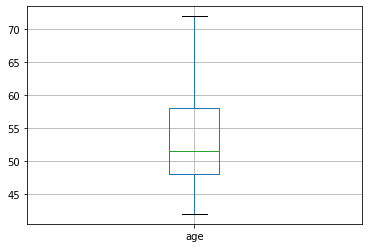

In [31]:
all_coaches_age.boxplot(column='age')

## [RQ4] 
Find the top 10 players with the highest ratio between completed passes and attempted passes. For this task, consider all the different types of passes, and as specified in the website, a completed pass has tag 1801 (accurate event).

In order to avoid meaningless results (e.g. players who played few minutes, and completed 2 passes over 2, achieving 100% ratio), select an arbitrary threshold of minimum attempted passes, in order to consider only the subset of players that played enough. Justify the choices you make.

In [32]:
# We need to consider only the premier league's teams

for i in range( len( teams["area"] ) ):
    
    if (teams["area"][i]["name"] != "England" and teams["area"][i]["name"] != "Wales") or teams["type"][i] != "club":
        teams.drop([i], axis = 0, inplace=True)
        
teams

,area,city,name,officialName,type,wyId
0,"{'name': 'England', 'id': '0', 'alpha3code': '...",Newcastle upon Tyne,Newcastle United,Newcastle United FC,club,1613
8,"{'name': 'England', 'id': '0', 'alpha3code': '...","Huddersfield, West Yorkshire",Huddersfield Town,Huddersfield Town FC,club,1673
19,"{'name': 'Wales', 'id': '0', 'alpha3code': 'XW...",Swansea,Swansea City,Swansea City AFC,club,10531
26,"{'name': 'England', 'id': '0', 'alpha3code': '...","Bournemouth, Dorset",AFC Bournemouth,AFC Bournemouth,club,1659
27,"{'name': 'England', 'id': '0', 'alpha3code': '...","Brighton, East Sussex",Brighton & Hove Albion,Brighton & Hove Albion FC,club,1651
39,"{'name': 'England', 'id': '0', 'alpha3code': '...","Burnley, Lancashire",Burnley,Burnley FC,club,1646
54,"{'name': 'England', 'id': '0', 'alpha3code': '...",Leicester,Leicester City,Leicester City FC,club,1631
55,"{'name': 'England', 'id': '0', 'alpha3code': '...",London,West Ham United,West Ham United FC,club,1633
56,"{'name': 'England', 'id': '0', 'alpha3code': '...",Stoke-on-Trent,Stoke City,Stoke City FC,club,1639
60,"{'name': 'England', 'id': '0', 'alpha3code': '...",Watford,Watford,Watford FC,club,1644


In [33]:
# We filter the events dataset to obtain only the "pass" events

pass_england = events_england[ events_england["eventName"] == "Pass" ]
pass_england.head()

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId
0,8,Pass,2.758649,177959171,2499719,1H,25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",85,Simple pass,[{'id': 1801}],1609
1,8,Pass,4.946850,177959172,2499719,1H,370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",83,High pass,[{'id': 1801}],1609
2,8,Pass,6.542188,177959173,2499719,1H,3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",82,Head pass,[{'id': 1801}],1609
3,8,Pass,8.143395,177959174,2499719,1H,120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",82,Head pass,[{'id': 1801}],1609
4,8,Pass,10.302366,177959175,2499719,1H,167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",85,Simple pass,[{'id': 1801}],1609


In [34]:
# We only consider the columns of data that could be usefull; then we rename one of the 2 columns "wyId"
# (in this case the one in players_RQ4) to not confuse these between the 2 dataset

players_RQ4 = players[ ["currentTeamId", "firstName", "lastName", "wyId"] ]
teams_RQ4 = teams[ ["name", "wyId"] ]

players_RQ4 = players_RQ4.rename(columns={"wyId":"wyIdPlayer"})
players_RQ4.head()

,currentTeamId,firstName,lastName,wyIdPlayer
0,4502,Harun,Tekin,32777
1,3775,Malang,Sarr,393228
2,3772,Over,Mandanda,393230
3,683,Alfred John Momar,N'Diaye,32793
4,2975,Ibrahima,Konat\u00e9,393247


In [35]:
teams_RQ4.head()

,name,wyId
0,Newcastle United,1613
8,Huddersfield Town,1673
19,Swansea City,10531
26,AFC Bournemouth,1659
27,Brighton & Hove Albion,1651


In [36]:
# We want associate each player to his team with pd.merge()

players_teams = pd.merge(players_RQ4, teams_RQ4, left_on="currentTeamId", right_on="wyId")
players_teams.head()

,currentTeamId,firstName,lastName,wyIdPlayer,name,wyId
0,1624,Toby,Alderweireld,36,Tottenham Hotspur,1624
1,1624,Jan,Vertonghen,48,Tottenham Hotspur,1624
2,1624,Christian,Dannemann Eriksen,54,Tottenham Hotspur,1624
3,1624,Danny,Rose,8292,Tottenham Hotspur,1624
4,1624,Harry,Kane,8717,Tottenham Hotspur,1624


In [37]:
# We can forget about the "wyId" column because this info is already in the "currentTeamId" column

players_teams.drop("wyId", axis=1, inplace=True)
players_teams.rename( columns={"name":"TeamName"}, inplace=True)
players_teams.head()

,currentTeamId,firstName,lastName,wyIdPlayer,TeamName
0,1624,Toby,Alderweireld,36,Tottenham Hotspur
1,1624,Jan,Vertonghen,48,Tottenham Hotspur
2,1624,Christian,Dannemann Eriksen,54,Tottenham Hotspur
3,1624,Danny,Rose,8292,Tottenham Hotspur
4,1624,Harry,Kane,8717,Tottenham Hotspur


In [38]:
# We define a new DataFrame, it contains all the playerID and the total number of pass that player did
# during the season

players_pass = pd.DataFrame( pass_england["playerId"].value_counts() )
players_pass.reset_index( level=0, inplace=True )
players_pass.rename( columns={ "playerId":"TotPass", "index":"playerId"}, inplace=True )
players_pass.head()

,playerId,TotPass
0,49876,2974
1,70086,2964
2,105339,2842
3,25553,2713
4,38021,2672


In [39]:
# Now we need to associate the "player_pass" DataFrame to the "players_team" DataFrame

players_pass = pd.merge( players_teams, players_pass, right_on="playerId", left_on="wyIdPlayer" )
players_pass.drop("wyIdPlayer", axis=1, inplace=True)
players_pass.head()

,currentTeamId,firstName,lastName,TeamName,playerId,TotPass
0,1624,Toby,Alderweireld,Tottenham Hotspur,36,898
1,1624,Jan,Vertonghen,Tottenham Hotspur,48,2370
2,1624,Christian,Dannemann Eriksen,Tottenham Hotspur,54,2196
3,1624,Danny,Rose,Tottenham Hotspur,8292,392
4,1624,Harry,Kane,Tottenham Hotspur,8717,594


In [40]:
# We reset the index of pass_england DataFrame and then we pick only the successful passage, denoted by "id" 1801.
# Such "id" always occurs as the last element of the list pass_england["tags"][row], so it is possible to accede 
# to it by pass_england["tags"][i][-1] for every row i in the DataFrame

pass_england.reset_index(drop=True, inplace=True)
pass_success = pass_england[[pass_england["tags"][i][-1]["id"]==1801 for i in range(pass_england.shape[0])]]
pass_success.head()

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId
0,8,Pass,2.758649,177959171,2499719,1H,25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",85,Simple pass,[{'id': 1801}],1609
1,8,Pass,4.946850,177959172,2499719,1H,370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",83,High pass,[{'id': 1801}],1609
2,8,Pass,6.542188,177959173,2499719,1H,3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",82,Head pass,[{'id': 1801}],1609
3,8,Pass,8.143395,177959174,2499719,1H,120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",82,Head pass,[{'id': 1801}],1609
4,8,Pass,10.302366,177959175,2499719,1H,167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",85,Simple pass,[{'id': 1801}],1609


In [41]:
# Now we can count, for each player, the number of successful passes and define a new DataFrame with 
# these informations

players_success_pass = pd.DataFrame( pass_success["playerId"].value_counts() )
players_success_pass.reset_index( level=0, inplace=True )
players_success_pass.rename( columns={ "playerId":"TotSuccPass", "index":"playerId2"}, inplace=True )
players_success_pass.head()

,playerId2,TotSuccPass
0,70086,2779
1,49876,2634
2,105339,2609
3,25553,2359
4,38021,2183


In [42]:
# Then we merge the latest informationn on the players_pass DataFrame

players_pass = pd.merge( players_pass, players_success_pass, left_on="playerId", right_on="playerId2" )
players_pass.drop("playerId2", axis=1, inplace=True)
players_pass.head()

,currentTeamId,firstName,lastName,TeamName,playerId,TotPass,TotSuccPass
0,1624,Toby,Alderweireld,Tottenham Hotspur,36,898,790
1,1624,Jan,Vertonghen,Tottenham Hotspur,48,2370,2113
2,1624,Christian,Dannemann Eriksen,Tottenham Hotspur,54,2196,1803
3,1624,Danny,Rose,Tottenham Hotspur,8292,392,306
4,1624,Harry,Kane,Tottenham Hotspur,8717,594,439


In [43]:
# We can evaluate the rate of successful passages for each player dividing column TotSuccessPass with column TotPass.
# Then we sort the data frame according to this rate, in descending order 

players_pass = pd.concat([players_pass, players_pass.TotSuccPass/players_pass.TotPass], axis=1)
players_pass.rename( columns={0:"RatePass"}, inplace=True)
players_pass.sort_values(by=["RatePass"], ascending=False, inplace=True)
players_pass

,currentTeamId,firstName,lastName,TeamName,playerId,TotPass,TotSuccPass,RatePass
116,1619,Michael,Obafemi,Southampton,447538,1,1,1.000000
241,1628,Pape,N'Diaye Souar\u00e9,Crystal Palace,25703,9,9,1.000000
378,1659,Jack,Simpson,AFC Bournemouth,415747,6,6,1.000000
158,1610,Ethan,Ampadu,Chelsea,423162,18,18,1.000000
61,1627,Rekeem,Harper,West Bromwich Albion,447254,4,4,1.000000
170,1625,John,Stones,Manchester City,9380,1204,1175,0.975914
169,1625,Fabian,Delph,Manchester City,8464,1584,1497,0.945076
166,1625,Vincent,Kompany,Manchester City,8307,1391,1312,0.943206
139,1610,Andreas,Christensen,Chelsea,135103,1288,1211,0.940217
188,1611,Phil,Jones,Manchester United,7918,1057,992,0.938505


In [44]:
# Filter for too low number of passes

players_pass = players_pass[ players_pass.TotPass > 100 ].sort_values(by=["RatePass"], ascending=False)
players_pass.head()

,currentTeamId,firstName,lastName,TeamName,playerId,TotPass,TotSuccPass,RatePass
170,1625,John,Stones,Manchester City,9380,1204,1175,0.975914
169,1625,Fabian,Delph,Manchester City,8464,1584,1497,0.945076
166,1625,Vincent,Kompany,Manchester City,8307,1391,1312,0.943206
139,1610,Andreas,Christensen,Chelsea,135103,1288,1211,0.940217
188,1611,Phil,Jones,Manchester United,7918,1057,992,0.938505


In [45]:
# A bit of Stat

mean_pass = players_pass.TotPass.mean()
std_pass = players_pass.TotPass.std()

In [46]:
# Filter with the Stat results

players_pass = players_pass[ players_pass.TotPass > mean_pass - std_pass ].sort_values(by=["RatePass"], 
                                                                                       ascending=False)
players_pass.reset_index( level=0, inplace=True )
players_pass.head()

,index,currentTeamId,firstName,lastName,TeamName,playerId,TotPass,TotSuccPass,RatePass
0,170,1625,John,Stones,Manchester City,9380,1204,1175,0.975914
1,169,1625,Fabian,Delph,Manchester City,8464,1584,1497,0.945076
2,166,1625,Vincent,Kompany,Manchester City,8307,1391,1312,0.943206
3,139,1610,Andreas,Christensen,Chelsea,135103,1288,1211,0.940217
4,188,1611,Phil,Jones,Manchester United,7918,1057,992,0.938505


### Find the top 10 players with the highest ratio between completed passes and attempted passes.

In [47]:
# Finally, the players top 10 by successful passage rate

players_pass[:10]

,index,currentTeamId,firstName,lastName,TeamName,playerId,TotPass,TotSuccPass,RatePass
0,170,1625,John,Stones,Manchester City,9380,1204,1175,0.975914
1,169,1625,Fabian,Delph,Manchester City,8464,1584,1497,0.945076
2,166,1625,Vincent,Kompany,Manchester City,8307,1391,1312,0.943206
3,139,1610,Andreas,Christensen,Chelsea,135103,1288,1211,0.940217
4,188,1611,Phil,Jones,Manchester United,7918,1057,992,0.938505
5,161,1625,Nicol\u00e1s Hern\u00e1n,Otamendi,Manchester City,70086,2964,2779,0.937584
6,84,1609,Mohamed Naser,Elsayed Elneny,Arsenal,120339,834,781,0.936451
7,173,1625,\u0130lkay,G\u00fcndo\u011fan,Manchester City,14808,1350,1263,0.935556
8,185,1611,Victor,Nilsson Lindel\u00f6f,Manchester United,71703,729,682,0.935528
9,6,1624,Moussa Sidi Yaya,Demb\u00e9l\u00e9,Tottenham Hotspur,11152,1365,1273,0.932601


## [RQ5] 
Does being a tall player mean winning more air duels? Soccer is a physical game, and it happens often in a match that players are involved in air duels (i.e. when two players are contending for the ball while it is not on the ground). Make a plot that shows the dependency between height of the player and the ratio of air duels won with air duels attempted. The visualization should be a scatterplot, where each point (x,y) represent a player whose height is equal to x, and that has a ratio of winning air duels equal to y. Furthermore, color any point according an arbitrary selection of categories of height (e.g. yellow: 160-165cm, orange: 165-170cm, etc.)

Remember that the "Air Duel" is a subevent of the event "Duel" and that an air duel is said to be won if it has the tag "1801". Same as in RQ4, choose a threshold of minimum air duels attempted, in order filter your data, get reliable results, and justify your choice.

In [49]:
dataset = events_england

In [51]:
#selecting only air duels
eventofinterest=dataset[dataset["subEventName"]=='Air duel']
eventofinterest.reset_index(inplace=True,drop=True)
eventofinterest.head()

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId
0,1,Duel,14.765321,177959189,2499719,1H,8013,"[{'y': 15, 'x': 39}, {'y': 20, 'x': 33}]",10,Air duel,"[{'id': 701}, {'id': 1802}]",1631
1,1,Duel,14.765321,177961218,2499719,1H,0,"[{'y': 85, 'x': 61}, {'y': 80, 'x': 67}]",10,Air duel,"[{'id': 703}, {'id': 1801}]",1609
2,1,Duel,21.878309,177959191,2499719,1H,8653,"[{'y': 46, 'x': 29}, {'y': 41, 'x': 50}]",10,Air duel,"[{'id': 703}, {'id': 1801}]",1631
3,1,Duel,22.551816,177959181,2499719,1H,25413,"[{'y': 54, 'x': 71}, {'y': 59, 'x': 50}]",10,Air duel,"[{'id': 701}, {'id': 1802}]",1609
4,1,Duel,47.717508,177959210,2499719,1H,192748,"[{'y': 56, 'x': 60}, {'y': 49, 'x': 56}]",10,Air duel,"[{'id': 703}, {'id': 1801}]",1631


In [52]:
# data set says that if tags 1801 then it is a successive event.
#Filtering only the data that they are equal to 1801
eventofsucessive=eventofinterest[[eventofinterest["tags"][i][1]['id'] == 1801 for i in range(eventofinterest["tags"].shape[0])]]

In [53]:
eventofsucessive.drop(["positions","matchId","teamId","matchPeriod","id"],axis=1,inplace=True)
eventofsucessive.head()

,eventId,eventName,eventSec,playerId,subEventId,subEventName,tags
1,1,Duel,14.765321,0,10,Air duel,"[{'id': 703}, {'id': 1801}]"
2,1,Duel,21.878309,8653,10,Air duel,"[{'id': 703}, {'id': 1801}]"
4,1,Duel,47.717508,192748,10,Air duel,"[{'id': 703}, {'id': 1801}]"
7,1,Duel,178.317724,120339,10,Air duel,"[{'id': 703}, {'id': 1801}]"
9,1,Duel,254.036308,14763,10,Air duel,"[{'id': 703}, {'id': 1801}]"


In [54]:
#groupby the players and count them
succesivecount=eventofsucessive.groupby("playerId").count()
succesivecount.drop(["subEventName","tags","eventName","eventSec","subEventId"],axis=1,inplace=True)
succesivecount.reset_index(inplace=True)
succesivecount.head()

,playerId,eventId
0,0,1129
1,36,27
2,38,12
3,48,152
4,54,22


In [55]:
teamdata=players
teamdata=teamdata[["firstName","middleName","lastName","height","wyId"]]
teamdata.head()


,firstName,middleName,lastName,height,wyId
0,Harun,,Tekin,187,32777
1,Malang,,Sarr,182,393228
2,Over,,Mandanda,176,393230
3,Alfred John Momar,,N'Diaye,187,32793
4,Ibrahima,,Konat\u00e9,192,393247


In [56]:
#to finding player name merge them on player Id
lastdata=succesivecount.merge(teamdata,left_on="playerId",right_on="wyId")
lastdata.drop("wyId",axis=1,inplace=True)
lastdata.head()

,playerId,eventId,firstName,middleName,lastName,height
0,36,27,Toby,,Alderweireld,187
1,38,12,Daley,,Blind,180
2,48,152,Jan,,Vertonghen,189
3,54,22,Christian,,Dannemann Eriksen,180
4,56,3,Davy,,Klaassen,179


In [57]:
#total number of passes that each player done 
eventoftotal=eventofinterest.groupby("playerId").count()
eventoftotal.reset_index(inplace=True)
eventoftotal=eventoftotal[["playerId","eventId"]]
eventoftotal.rename(columns={"eventId":"totalduel"},inplace=True)
eventoftotal.head()

,playerId,totalduel
0,0,2972
1,36,55
2,38,19
3,48,213
4,54,52


In [58]:
#merging both succesive duels and totalduels on player id
lastdata=lastdata.merge(eventoftotal,left_on="playerId",right_on="playerId")
lastdata.rename(columns={"eventId":"succesiveduel"},inplace=True)
lastdata.head()

,playerId,succesiveduel,firstName,middleName,lastName,height,totalduel
0,36,27,Toby,,Alderweireld,187,55
1,38,12,Daley,,Blind,180,19
2,48,152,Jan,,Vertonghen,189,213
3,54,22,Christian,,Dannemann Eriksen,180,52
4,56,3,Davy,,Klaassen,179,8


In [59]:
#calculating ratio between successive and all air duel
lastdata["ratio"]=lastdata["succesiveduel"]/lastdata["totalduel"]

In [60]:
#if total duel less then 50 , find their mean and remove their standart deviation to filter ratio
lastdata=lastdata.sort_values(by="totalduel").reset_index(drop=True)
lastdata=lastdata[lastdata["totalduel"]>=
         lastdata[lastdata["totalduel"]>=50]["totalduel"].mean()-(lastdata[lastdata["totalduel"]>=50]["totalduel"].std())/2]

In [61]:
lastdata=lastdata.sort_values(by="ratio",ascending=False).reset_index(drop=True)
lastdata.head()

,playerId,succesiveduel,firstName,middleName,lastName,height,totalduel,ratio
0,135103,76,Andreas,,Christensen,188,96,0.791667
1,7887,106,Gary,,Cahill,193,134,0.791045
2,25854,132,Kurt Happy,,Zouma,190,170,0.776471
3,8242,253,Shane,,Duffy,193,337,0.750742
4,7922,143,Chris,,Smalling,193,192,0.744792


### Does being a tall player mean winning more air duels?

Text(0.5, 1.0, 'Height-Succes Ratio')

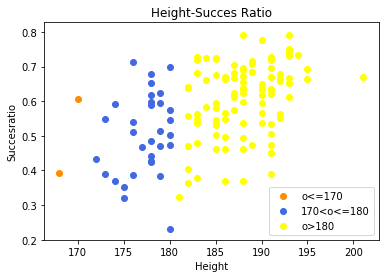

In [62]:
# plt.figure(figsize=(10,7))
colormap=np.array(["r","g","b"])
categories=np.array(list(range(lastdata.shape[0])))
plt.scatter(lastdata[lastdata["height"]<=170].height,
            lastdata[lastdata["height"]<=170].ratio,color="darkorange",label="o<=170")
plt.scatter(lastdata[(lastdata["height"]<=180)&(lastdata["height"]>170)].height,
            lastdata[(lastdata["height"]<=180)&(lastdata["height"]>170)].ratio,color="royalblue",
            label="170<o<=180")
plt.scatter(lastdata[lastdata["height"]>180].height,
            lastdata[lastdata["height"]>180].ratio,color="yellow",label="o>180")
plt.legend()
plt.xlabel("Height")
plt.ylabel("Succesratio")
plt.title("Height-Succes Ratio")

### [RQ6] 
Free your mind! Go further with the EDA (Exploratory Data Analysis) showing a new interesting result about the dataset that you found.

## Goal
In the following lines an analysis will be carried out on the relationship between the average age of a team and the score obtained by it at the end of the championship.


### Getting all players with ages and relative teams

In [63]:
players_team = pd.merge(players, teams, left_on ="currentTeamId", right_on = "wyId")

In [64]:
players_team1 = players_team[['birthDate', 'shortName', 'area', 'name', 'type' ]]
players_team1.head()

,birthDate,shortName,area,name,type
0,1989-03-02,T. Alderweireld,"{'name': 'England', 'id': '0', 'alpha3code': '...",Tottenham Hotspur,club
1,1987-04-24,J. Vertonghen,"{'name': 'England', 'id': '0', 'alpha3code': '...",Tottenham Hotspur,club
2,1992-02-14,C. Eriksen,"{'name': 'England', 'id': '0', 'alpha3code': '...",Tottenham Hotspur,club
3,1990-07-02,D. Rose,"{'name': 'England', 'id': '0', 'alpha3code': '...",Tottenham Hotspur,club
4,1993-07-28,H. Kane,"{'name': 'England', 'id': '0', 'alpha3code': '...",Tottenham Hotspur,club


In [65]:
players_team1.reset_index(drop=True,inplace=True) # getting a new index for the data
players_team1['age'] = [2019-int(players_team1['birthDate'][i][0:4]) for i in range(players_team1.shape[0])] # adding column age for each coach
players_team2 = players_team1[['shortName','age','name']]
players_team2.head()

,shortName,age,name
0,T. Alderweireld,30,Tottenham Hotspur
1,J. Vertonghen,32,Tottenham Hotspur
2,C. Eriksen,27,Tottenham Hotspur
3,D. Rose,29,Tottenham Hotspur
4,H. Kane,26,Tottenham Hotspur


## Getting all teams and relative final score

In [66]:
interestofdata=matches_england[["gameweek","winner","label"]]
interestofdata.head()

,gameweek,winner,label
0,38,1659,"Burnley - AFC Bournemouth, 1 - 2"
1,38,1628,"Crystal Palace - West Bromwich Albion, 2 - 0"
2,38,1609,"Huddersfield Town - Arsenal, 0 - 1"
3,38,1612,"Liverpool - Brighton & Hove Albion, 4 - 0"
4,38,1611,"Manchester United - Watford, 1 - 0"


In [67]:
#Here we just seperate the team name from each other 
x=[]
for i in range(interestofdata.shape[0]):
    x.append([interestofdata["label"].str.split(",")[i][0].split("-")[0],interestofdata["label"].str.split(",")[i][0].split("-")[1]])
x[:10]

[['Burnley ', ' AFC Bournemouth'],
 ['Crystal Palace ', ' West Bromwich Albion'],
 ['Huddersfield Town ', ' Arsenal'],
 ['Liverpool ', ' Brighton & Hove Albion'],
 ['Manchester United ', ' Watford'],
 ['Newcastle United ', ' Chelsea'],
 ['Southampton ', ' Manchester City'],
 ['Swansea City ', ' Stoke City'],
 ['Tottenham Hotspur ', ' Leicester City'],
 ['West Ham United ', ' Everton']]

In [68]:
# New data frame with Home - Away teams seperated
x=pd.DataFrame(x)
x.columns=["team1name","team2name"]
interestofdata=pd.concat([x,interestofdata],axis=1)
interestofdata
interestofdata.drop("label",axis=1,inplace=True)
interestofdata.head()

,team1name,team2name,gameweek,winner
0,Burnley,AFC Bournemouth,38,1659
1,Crystal Palace,West Bromwich Albion,38,1628
2,Huddersfield Town,Arsenal,38,1609
3,Liverpool,Brighton & Hove Albion,38,1612
4,Manchester United,Watford,38,1611


In [69]:
interestofdata.sort_values(by="gameweek",inplace=True)
interestofdata.reset_index(drop=True,inplace=True)
interestofdata.head(10)

,team1name,team2name,gameweek,winner
0,Arsenal,Leicester City,1,1609
1,Manchester United,West Ham United,1,1611
2,Newcastle United,Tottenham Hotspur,1,1624
3,Brighton & Hove Albion,Manchester City,1,1625
4,Chelsea,Burnley,1,1646
5,Watford,Liverpool,1,0
6,Everton,Stoke City,1,1623
7,Southampton,Swansea City,1,0
8,West Bromwich Albion,AFC Bournemouth,1,1627
9,Crystal Palace,Huddersfield Town,1,1673


In [70]:
# matching teams name with their ids by finding it in team datas
holder=[]
for i in range(interestofdata.shape[0]):
    holder.append((teams[teams["name"]==interestofdata.loc[i,"team1name"].rstrip()]["wyId"].values[0],
                  teams[teams["name"]==interestofdata.loc[i,"team2name"].lstrip()]["wyId"].values[0]))
holder[:10]

[(1609, 1631),
 (1611, 1633),
 (1613, 1624),
 (1651, 1625),
 (1610, 1646),
 (1644, 1612),
 (1623, 1639),
 (1619, 10531),
 (1627, 1659),
 (1628, 1673)]

In [71]:
#concat the team id dataset and interest of data
seconddata=pd.concat([pd.DataFrame(holder,columns=["team1code","team2code"]),interestofdata],axis=1)
seconddata.head()

,team1code,team2code,team1name,team2name,gameweek,winner
0,1609,1631,Arsenal,Leicester City,1,1609
1,1611,1633,Manchester United,West Ham United,1,1611
2,1613,1624,Newcastle United,Tottenham Hotspur,1,1624
3,1651,1625,Brighton & Hove Albion,Manchester City,1,1625
4,1610,1646,Chelsea,Burnley,1,1646


In [72]:
# there is a spaces at teamdatas because of splitting them. They are removed here.
seconddata["team2name"]=seconddata["team2name"].str.lstrip()
seconddata["team1name"]=seconddata["team1name"].str.rstrip()

In [73]:
# These code chunks iterate over all data set and it looks for winner column. Datas are stored in order dict
#if it equal 0  it ats both team 1
#if winner is first team it adds 3 points to winner and 0 to its oppenents and vice versa 
teamtotalscores=defaultdict(list)
for i in range(seconddata.shape[0]):
    if seconddata.iloc[i,5] == 0:
        teamtotalscores[seconddata.iloc[i,3]].append(1)
        teamtotalscores[seconddata.iloc[i,2]].append(1)
        
    elif seconddata.iloc[i,0] == seconddata.iloc[i,5]:
        teamtotalscores[seconddata.iloc[i,2]].append(3)
        teamtotalscores[seconddata.iloc[i,3]].append(0)
    elif seconddata.iloc[i,1] == seconddata.iloc[i,5]:
        teamtotalscores[seconddata.iloc[i,3]].append(3)
        teamtotalscores[seconddata.iloc[i,2]].append(0)

In [74]:
#consecutive winner counter
consecutivewin=defaultdict(list)
for keys in teamtotalscores.keys():
    counter = 0
    for values in teamtotalscores[keys]:
        if values == 3:
            counter += 1
        elif values != 3: 
            consecutivewin[keys].append(counter)
            counter=0
        

In [75]:
for keys in consecutivewin.keys():
    consecutivewin[keys]= max(consecutivewin[keys])

In [76]:
#cumsum of each team by the weeks
x=pd.DataFrame(teamtotalscores).set_index([["w\n{}".format(i) for i in range(1,39)]],drop=True).cumsum()

# total sum for each team
y = x.tail(1)
y['Index'] = 'Score'
y

,Arsenal,Leicester City,Manchester United,West Ham United,Tottenham Hotspur,Newcastle United,Manchester City,Brighton & Hove Albion,Burnley,Chelsea,...,Watford,Everton,Stoke City,Swansea City,Southampton,West Bromwich Albion,AFC Bournemouth,Huddersfield Town,Crystal Palace,Index
w\n38,63,47,81,42,77,44,100,41,54,70,...,39,48,33,33,36,31,44,37,44,Score


In [77]:
team_final_score = y.set_index('Index').T.sort_values(by='Score') # Changing columns in row
team_final_score.head()

Index,Score
West Bromwich Albion,31
Swansea City,33
Stoke City,33
Southampton,36
Huddersfield Town,37


In [78]:
players_team2.head() # showing the dataset for the next step

,shortName,age,name
0,T. Alderweireld,30,Tottenham Hotspur
1,J. Vertonghen,32,Tottenham Hotspur
2,C. Eriksen,27,Tottenham Hotspur
3,D. Rose,29,Tottenham Hotspur
4,H. Kane,26,Tottenham Hotspur


In [79]:
team_age2 = players_team2.set_index(['name']) # setting officialName as index to work on the age

team_age2_by_g = team_age2.groupby(level=team_age2.index.names.difference(['age'])) # I've separated all the teams keeping all the ages
mean_age_team = team_age2_by_g.mean() # and then I calculated the mean for each group
mean_age_team.head()


,age
name,
AFC Bournemouth,27.869565
Arsenal,28.050000
Brighton & Hove Albion,29.444444
Burnley,30.136364
Chelsea,28.750000


In [80]:
mean_age_team['Score'] = team_final_score['Score'] # I merge the two dataset to obtain the score related with the mean age.


### Looking for a relation between the mean age of team and the final Score obtained

In [81]:
mean_age_team_sort = mean_age_team.sort_values(by='Score')
mean_age_team_sort

,age,Score
name,,
West Bromwich Albion,28.590909,31
Swansea City,28.058824,33
Stoke City,28.000000,33
Southampton,27.238095,36
Huddersfield Town,27.285714,37
Watford,29.739130,39
Brighton & Hove Albion,29.444444,41
West Ham United,29.111111,42
Newcastle United,27.666667,44


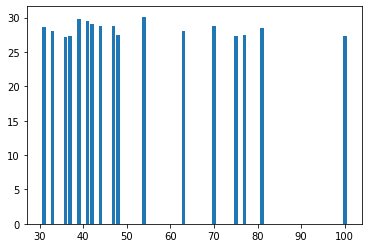

In [82]:
plt.bar(mean_age_team_sort['Score'], mean_age_team_sort['age'])
plt.show()

### Comments on the result
With this result we can clearly see that in the case of England there isn't correlation between the mean age and the final score obtained by the team. The analysis is pretty trivial but our goal was to understand how to work on this kind of data.


## CRQ-1 


[CRQ1] What are the time slots of the match with more goals? Let's analyse and visualise the goals distribution into 9-minutes sets for all the matches. I.e., let's transform the minute of a goal from a continuous variable in a discrete variable (e.g. A goal scored in 5th minute, will end up in the interval [0-9)). Remind that every match goes usually from minute 0, to minute 90, but in football it is always added an arbitary amount of extra-time to every half of the match, thus consider also the intervals "45+" and "90+".

    Make a barplot with the absolute frequency of goals in all the time slots.
    Find the top 10 teams that score the most in the interval "81-90".
    Show if there are players that were able to score at least one goal in 8 different intervals.

In [89]:
matches_england.head()

,competitionId,date,dateutc,duration,gameweek,label,referees,roundId,seasonId,status,teamsData,venue,winner,wyId
0,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Burnley - AFC Bournemouth, 1 - 2","[{'refereeId': 385705, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",Turf Moor,1659,2500089
1,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Crystal Palace - West Bromwich Albion, 2 - 0","[{'refereeId': 381851, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",Selhurst Park,1628,2500090
2,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Huddersfield Town - Arsenal, 0 - 1","[{'refereeId': 384965, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",The John Smith's Stadium,1609,2500091
3,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Liverpool - Brighton & Hove Albion, 4 - 0","[{'refereeId': 385704, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1651': {'scoreET': 0, 'coachId': 8093, 'side...",Anfield,1612,2500092
4,364,"May 13, 2018 at 4:00:00 PM GMT+2",2018-05-13 14:00:00,Regular,38,"Manchester United - Watford, 1 - 0","[{'refereeId': 381853, 'role': 'referee'}, {'r...",4405654,181150,Played,"{'1644': {'scoreET': 0, 'coachId': 93112, 'sid...",Old Trafford,1611,2500093


In [90]:
events_england.head()

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId
0,8,Pass,2.758649,177959171,2499719,1H,25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",85,Simple pass,[{'id': 1801}],1609
1,8,Pass,4.946850,177959172,2499719,1H,370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",83,High pass,[{'id': 1801}],1609
2,8,Pass,6.542188,177959173,2499719,1H,3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",82,Head pass,[{'id': 1801}],1609
3,8,Pass,8.143395,177959174,2499719,1H,120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",82,Head pass,[{'id': 1801}],1609
4,8,Pass,10.302366,177959175,2499719,1H,167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",85,Simple pass,[{'id': 1801}],1609


In [88]:
eventofshoot=events_england[events_england["subEventName"]=="Shot"]["tags"].reset_index(drop=False)
eventofshoot.rename(columns={"index":"exindex"},inplace=True)
eventofshoot.head()

,exindex,tags
0,46,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':..."
1,62,"[{'id': 401}, {'id': 201}, {'id': 1211}, {'id'..."
2,91,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':..."
3,128,"[{'id': 401}, {'id': 201}, {'id': 1215}, {'id'..."
4,249,"[{'id': 402}, {'id': 201}, {'id': 1205}, {'id'..."


In [91]:
#if eventof shoot tags == 101 select them and filter the data by if they are true 
goals=[]
counter=0
for i in range(eventofshoot.shape[0]):
    goals.append(eventofshoot["tags"][i][0]["id"]==101)
        
goals=eventofshoot[goals]
goals.drop(["tags"],axis=1,inplace=True)
goals.head()

,exindex
0,46
2,91
10,554
14,898
18,1107


In [92]:
#selecting the only goal shoots from events of england
events_england=events_england.loc[goals["exindex"]]
events_england.head()

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId
46,10,Shot,94.595788,177959212,2499719,1H,25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",100,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",1609
91,10,Shot,254.745027,177959280,2499719,1H,14763,"[{'y': 52, 'x': 96}, {'y': 100, 'x': 100}]",100,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",1631
554,10,Shot,1710.855093,177959759,2499719,1H,12829,"[{'y': 54, 'x': 94}, {'y': 100, 'x': 100}]",100,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",1631
898,10,Shot,2815.900791,177960130,2499719,1H,7945,"[{'y': 50, 'x': 92}, {'y': 0, 'x': 0}]",100,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",1609
1107,10,Shot,634.312236,177960379,2499719,2H,12829,"[{'y': 54, 'x': 92}, {'y': 100, 'x': 100}]",100,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",1631


In [93]:
#converting seconds to minute 
events_england["eventSec"]= events_england["eventSec"]/60
events_england.head()

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId
46,10,Shot,1.576596,177959212,2499719,1H,25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",100,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",1609
91,10,Shot,4.245750,177959280,2499719,1H,14763,"[{'y': 52, 'x': 96}, {'y': 100, 'x': 100}]",100,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",1631
554,10,Shot,28.514252,177959759,2499719,1H,12829,"[{'y': 54, 'x': 94}, {'y': 100, 'x': 100}]",100,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",1631
898,10,Shot,46.931680,177960130,2499719,1H,7945,"[{'y': 50, 'x': 92}, {'y': 0, 'x': 0}]",100,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",1609
1107,10,Shot,10.571871,177960379,2499719,2H,12829,"[{'y': 54, 'x': 92}, {'y': 100, 'x': 100}]",100,Shot,"[{'id': 101}, {'id': 403}, {'id': 201}, {'id':...",1631


In [94]:
#converting columns in to integer and assign them into specified intervals
events_england["eventSec"]=events_england["eventSec"].astype(int)
events_england['interval'] = np.digitize(events_england['eventSec'], [i for i in range(9,55,9)], right=True) + 1

In [95]:
# for the second half add 6 to interval
events_england.loc[events_england[events_england["matchPeriod"]=="2H"].index,"interval"] += 6

In [96]:
# grouping by intervals
data=events_england.groupby("interval").count()
data

,eventId,eventName,eventSec,id,matchId,matchPeriod,playerId,positions,subEventId,subEventName,tags,teamId
interval,,,,,,,,,,,,
1,74,74,74,74,74,74,74,74,74,74,74,74
2,74,74,74,74,74,74,74,74,74,74,74,74
3,77,77,77,77,77,77,77,77,77,77,77,77
4,69,69,69,69,69,69,69,69,69,69,69,69
5,82,82,82,82,82,82,82,82,82,82,82,82
6,12,12,12,12,12,12,12,12,12,12,12,12
7,106,106,106,106,106,106,106,106,106,106,106,106
8,99,99,99,99,99,99,99,99,99,99,99,99
9,94,94,94,94,94,94,94,94,94,94,94,94


### Goal frequencies Bar plot

Text(0.5, 1.0, 'Goal Frequencies in Time Interval')

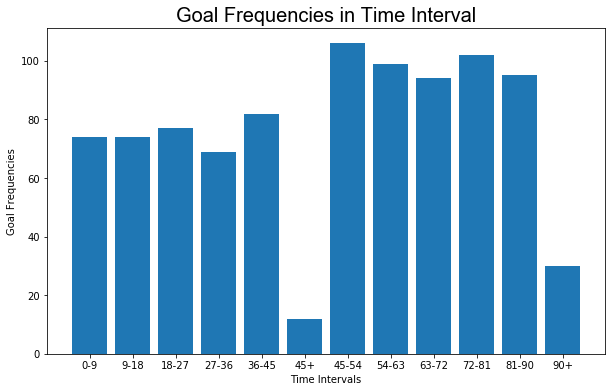

In [97]:
plt.figure(figsize=(10,6))
plt.bar(data.index,data.iloc[:,1],tick_label=["0-9","9-18","18-27","27-36","36-45","45+","45-54","54-63","63-72","72-81","81-90","90+"])
plt.xlabel("Time Intervals")
plt.ylabel("Goal Frequencies")

plt.title("Goal Frequencies in Time Interval",fontname='Arial',fontsize=20)

In [99]:
teamsdata=teams
teamsdata=teamsdata[["name","wyId"]]

In [100]:
#finding the topten score team 
toptenteam=events_england[events_england["interval"]==11].groupby("teamId").count().sort_values(
    "eventId",ascending=False).iloc[:10].reset_index().merge(teamsdata,left_on="teamId",right_on="wyId")[["eventId","name"]]

### Top ten score n interval 81-90

In [101]:
toptenteam.rename(columns={"eventId":"81-90 goals"},inplace=True)
toptenteam

,81-90 goals,name
0,13,Manchester City
1,10,Manchester United
2,8,Arsenal
3,7,Chelsea
4,7,Liverpool
5,7,Watford
6,7,Tottenham Hotspur
7,5,AFC Bournemouth
8,5,West Ham United
9,5,Crystal Palace


In [102]:
playerid=[]
for i in pd.unique(events_england["playerId"]):
    if len(pd.unique(events_england.groupby("playerId").get_group(i)["interval"])) >= 8 :
        playerid.append(i)

In [103]:
dataset=players
dataset=dataset[dataset["wyId"].isin(playerid)]

### People who score at least 8 times intervals


In [104]:
dataset[["firstName","lastName"]]

,firstName,lastName
671,Romelu,Lukaku Menama
745,Harry,Kane
841,Raheem Shaquille,Sterling
910,Gabriel Fernando,de Jesus
917,Jamie,Vardy
1191,Roberto Firmino,Barbosa de Oliveira
1719,Mohamed,Salah Ghaly
1800,Sadio,Man\u00e9
2990,Alexandre,Lacazette
3018,Wilfried,Zaha


## [CRQ2] 
Visualize movements and passes on the pitch! Here we try to focus our attention on the zones that a player covers during a match. For each event, we have a pair of coordinates, that are respectively the starting and ending point of that event. It can be helpful to follow this link.

### 1-)PART

In [23]:
eventsdata=pd.read_json("../HW2/events/events_Spain.json")
eventsdata.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],3542,"[{'y': 61, 'x': 37}, {'y': 50, 'x': 50}]",2565548,Pass,682,1H,2.994582,85,180864419
1,8,Simple pass,[{'id': 1801}],274435,"[{'y': 50, 'x': 50}, {'y': 30, 'x': 45}]",2565548,Pass,682,1H,3.137020,85,180864418
2,8,Simple pass,[{'id': 1801}],364860,"[{'y': 30, 'x': 45}, {'y': 12, 'x': 38}]",2565548,Pass,682,1H,6.709668,85,180864420
3,8,Simple pass,[{'id': 1801}],3534,"[{'y': 12, 'x': 38}, {'y': 69, 'x': 32}]",2565548,Pass,682,1H,8.805497,85,180864421
4,8,Simple pass,[{'id': 1801}],3695,"[{'y': 69, 'x': 32}, {'y': 37, 'x': 31}]",2565548,Pass,682,1H,14.047492,85,180864422


In [24]:
matches_Spain=pd.read_json("../HW2/matches/matches_Spain.json")
matches_Spain.head()

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4406122,38,"{'676': {'scoreET': 0, 'coachId': 92894, 'side...",181144,2018-05-20 18:45:00,676,Camp Nou,2565922,"Barcelona - Real Sociedad, 1 - 0","May 20, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 398931, 'role': 'referee'}, {'r...",Regular,795
1,Played,4406122,38,"{'679': {'scoreET': 0, 'coachId': 3427, 'side'...",181144,2018-05-20 16:30:00,0,Estadio Wanda Metropolitano,2565925,"Atl\u00e9tico Madrid - Eibar, 2 - 2","May 20, 2018 at 6:30:00 PM GMT+2","[{'refereeId': 395056, 'role': 'referee'}, {'r...",Regular,795
2,Played,4406122,38,"{'691': {'scoreET': 0, 'coachId': 444778, 'sid...",181144,2018-05-20 14:15:00,691,San Mam\u00e9s Barria,2565919,"Athletic Club - Espanyol, 0 - 1","May 20, 2018 at 4:15:00 PM GMT+2","[{'refereeId': 384957, 'role': 'referee'}, {'r...",Regular,795
3,Played,4406122,38,"{'674': {'scoreET': 0, 'coachId': 210074, 'sid...",181144,2018-05-20 10:00:00,674,Estadio de Mestalla,2565924,"Valencia - Deportivo La Coru\u00f1a, 2 - 1","May 20, 2018 at 12:00:00 PM GMT+2","[{'refereeId': 398913, 'role': 'referee'}, {'r...",Regular,795
4,Played,4406122,38,"{'675': {'scoreET': 0, 'coachId': 275283, 'sid...",181144,2018-05-19 18:45:00,0,Estadio de la Cer\u00e1mica,2565927,"Villarreal - Real Madrid, 2 - 2","May 19, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 395085, 'role': 'referee'}, {'r...",Regular,795


In [25]:
for c,i in enumerate(matches_Spain.dateutc,0):
    matches_Spain.loc[c,"dateutc"]=datetime.strptime(i,"%Y-%m-%d %H:%M:%f").strftime("%Y-%m-%d")

In [26]:
matches_Spain[(matches_Spain["dateutc"]== "2018-05-06")].loc[23]

status                                                      Played
roundId                                                    4406122
gameweek                                                        36
teamsData        {'675': {'scoreET': 0, 'coachId': 275283, 'sid...
seasonId                                                    181144
dateutc                                                 2018-05-06
winner                                                           0
venue                                                     Camp Nou
wyId                                                       2565907
label                               Barcelona - Real Madrid, 2 - 2
date                               May 6, 2018 at 8:45:00 PM GMT+2
referees         [{'refereeId': 378950, 'role': 'referee'}, {'r...
duration                                                   Regular
competitionId                                                  795
Name: 23, dtype: object

In [27]:
#barce
matchbetween=eventsdata[eventsdata["matchId"]==2565907]
matchbetween.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
593455,8,Simple pass,[{'id': 1801}],3321,"[{'y': 49, 'x': 50}, {'y': 40, 'x': 37}]",2565907,Pass,675,1H,3.274992,85,249644096
593456,8,Simple pass,[{'id': 1801}],14723,"[{'y': 40, 'x': 37}, {'y': 23, 'x': 30}]",2565907,Pass,675,1H,5.109197,85,249644097
593457,8,Simple pass,[{'id': 1801}],3306,"[{'y': 23, 'x': 30}, {'y': 57, 'x': 26}]",2565907,Pass,675,1H,7.109958,85,249644098
593458,8,Simple pass,[{'id': 1801}],3309,"[{'y': 57, 'x': 26}, {'y': 40, 'x': 8}]",2565907,Pass,675,1H,8.912297,85,249644099
593459,8,Simple pass,[{'id': 1801}],3915,"[{'y': 40, 'x': 8}, {'y': 14, 'x': 11}]",2565907,Pass,675,1H,11.290220,85,249644100


In [28]:
player_data=pd.read_json("../HW2/players.json")
player_data.head()

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konat\u00e9,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konat\u00e9,null


In [29]:
ronaldowyid=player_data[player_data["firstName"]=="Cristiano Ronaldo"]["wyId"].values
interestofdata=matchbetween[matchbetween["playerId"]==ronaldowyid[0]]

# The events to be considered are: passes, shoots, duels, free kicks.
ronaldo=interestofdata[interestofdata["eventName"].isin(["Duel","Pass","Shot","Free Kick"])]
ronaldo.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
593473,1,Ground loose ball duel,"[{'id': 702}, {'id': 1801}]",3322,"[{'y': 19, 'x': 49}, {'y': 17, 'x': 49}]",2565907,Duel,675,1H,68.618689,13,249644112
593475,1,Air duel,"[{'id': 701}, {'id': 1802}]",3322,"[{'y': 17, 'x': 49}, {'y': 19, 'x': 38}]",2565907,Duel,675,1H,69.411334,10,249644113
593497,1,Ground defending duel,"[{'id': 701}, {'id': 1802}]",3322,"[{'y': 13, 'x': 65}, {'y': 23, 'x': 53}]",2565907,Duel,675,1H,114.548692,12,249644119
593552,1,Ground attacking duel,"[{'id': 502}, {'id': 703}, {'id': 1801}]",3322,"[{'y': 12, 'x': 93}, {'y': 8, 'x': 97}]",2565907,Duel,675,1H,275.327960,11,249644145
593554,8,Cross,"[{'id': 401}, {'id': 801}, {'id': 1802}]",3322,"[{'y': 8, 'x': 97}, {'y': 100, 'x': 100}]",2565907,Pass,675,1H,277.578035,80,249644146


In [30]:
messiwyid=player_data[player_data["shortName"]=="L. Messi"]["wyId"].values
interestofdata=matchbetween[matchbetween["playerId"]==messiwyid[0]]
# The events to be considered are: passes, shoots, duels, free kicks.
messi=interestofdata[interestofdata["eventName"].isin(["Duel","Pass","Shot","Free Kick"])]
messi.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
593485,8,Simple pass,[{'id': 1801}],3359,"[{'y': 87, 'x': 74}, {'y': 91, 'x': 80}]",2565907,Pass,676,1H,85.701277,85,249644574
593489,8,Simple pass,[{'id': 1801}],3359,"[{'y': 87, 'x': 67}, {'y': 71, 'x': 43}]",2565907,Pass,676,1H,92.114223,85,249644578
593499,8,Simple pass,[{'id': 1801}],3359,"[{'y': 66, 'x': 58}, {'y': 78, 'x': 75}]",2565907,Pass,676,1H,117.241765,85,249644587
593501,1,Ground attacking duel,"[{'id': 702}, {'id': 1801}]",3359,"[{'y': 67, 'x': 65}, {'y': 38, 'x': 63}]",2565907,Duel,676,1H,122.168204,11,249644589
593503,8,Simple pass,[{'id': 1801}],3359,"[{'y': 38, 'x': 63}, {'y': 43, 'x': 69}]",2565907,Pass,676,1H,124.686582,85,249644590


In [31]:
def draw_pitch(ax):
    # focus on only half of the pitch
    #Pitch Outline & Centre Line
    Pitch = Rectangle([0,0], width = 120, height = 80, fill = False)
    #Left, Right Penalty Area and midline
    LeftPenalty = Rectangle([0,22.3], width = 14.6, height = 35.3, fill = False)
    RightPenalty = Rectangle([105.4,22.3], width = 14.6, height = 35.3, fill = False)
    midline = ConnectionPatch([60,0], [60,80], "data", "data")

    #Left, Right 6-yard Box
    LeftSixYard = Rectangle([0,32], width = 4.9, height = 16, fill = False)
    RightSixYard = Rectangle([115.1,32], width = 4.9, height = 16, fill = False)


    #Prepare Circles
    centreCircle = plt.Circle((60,40),8.1,color="black", fill = False)
    centreSpot = plt.Circle((60,40),0.71,color="black")
    #Penalty spots and Arcs around penalty boxes
    leftPenSpot = plt.Circle((9.7,40),0.71,color="black")
    rightPenSpot = plt.Circle((110.3,40),0.71,color="black")
    leftArc = Arc((9.7,40),height=16.2,width=16.2,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((110.3,40),height=16.2,width=16.2,angle=0,theta1=130,theta2=230,color="black")
    
    element = [Pitch, LeftPenalty, RightPenalty, midline, LeftSixYard, RightSixYard, centreCircle, 
               centreSpot, rightPenSpot, leftPenSpot, leftArc, rightArc]
    for i in element:
        ax.add_patch(i)

## Cristiano Ronaldo and L.Messi positon  graphs

Text(0.5, 1.0, 'L. Messi')

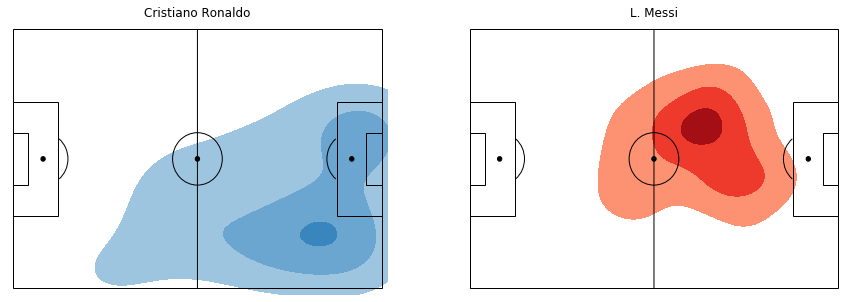

In [32]:
fig=plt.figure() #set up the figures
fig.set_size_inches(15, 5)
ax0=plt.subplot(1,2,1)
draw_pitch(ax0) #overlay our different objects on the pitch
sns.kdeplot([i[0]["x"]*1.2 for i in ronaldo.positions], [i[0]["y"]*0.8 for i in ronaldo.positions],
            n_levels=3,shade=True,shade_lowest=False)
plt.ylim(-2, 82)
plt.xlim(-2, 122)
plt.axis('off')
plt.title("Cristiano Ronaldo")
ax1=plt.subplot(1,2,2)
draw_pitch(ax1) #overlay our different objects on the pitch
sns.kdeplot([i[0]["x"]*1.2 for i in messi.positions], [i[0]["y"]*0.8 for i in messi.positions],
            shade=True,cmap="Reds",n_levels=3,shade_lowest=False)
plt.ylim(-2, 82)
plt.xlim(-2, 122)
plt.axis('off')
plt.title("L. Messi")


### PART-2 

In [33]:
italy_matches=pd.read_json("../HW2/matches/matches_Italy.json")
italy_matches.head()

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4406278,38,"{'3162': {'scoreET': 0, 'coachId': 251025, 'si...",181248,2018-05-20 18:45:00,3161,,2576335,"Lazio - Internazionale, 2 - 3","May 20, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 377206, 'role': 'referee'}, {'r...",Regular,524
1,Played,4406278,38,"{'3158': {'scoreET': 0, 'coachId': 210119, 'si...",181248,2018-05-20 18:45:00,3158,MAPEI Stadium - Citt\u00e0 del Tricolore,2576336,"Sassuolo - Roma, 0 - 1","May 20, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 377255, 'role': 'referee'}, {'r...",Regular,524
2,Played,4406278,38,"{'3173': {'scoreET': 0, 'coachId': 251044, 'si...",181248,2018-05-20 16:00:00,3173,,2576329,"Cagliari - Atalanta, 1 - 0","May 20, 2018 at 6:00:00 PM GMT+2","[{'refereeId': 377247, 'role': 'referee'}, {'r...",Regular,524
3,Played,4406278,38,"{'3165': {'scoreET': 0, 'coachId': 272970, 'si...",181248,2018-05-20 16:00:00,3165,,2576330,"Chievo - Benevento, 1 - 0","May 20, 2018 at 6:00:00 PM GMT+2","[{'refereeId': 377246, 'role': 'referee'}, {'r...",Regular,524
4,Played,4406278,38,"{'3166': {'scoreET': 0, 'coachId': 20481, 'sid...",181248,2018-05-20 16:00:00,3163,,2576331,"Udinese - Bologna, 1 - 0","May 20, 2018 at 6:00:00 PM GMT+2","[{'refereeId': 377254, 'role': 'referee'}, {'r...",Regular,524


In [34]:
liste=[]
for index,i in enumerate(italy_matches['dateutc'],0):
    liste.append(datetime.strptime(italy_matches.loc[index,"dateutc"],"%Y-%m-%d %H:%M:%f").strftime("%Y-%m-%d"))
italy_matches["dateutc"]=liste    

In [35]:
italy_matches.head()

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4406278,38,"{'3162': {'scoreET': 0, 'coachId': 251025, 'si...",181248,2018-05-20,3161,,2576335,"Lazio - Internazionale, 2 - 3","May 20, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 377206, 'role': 'referee'}, {'r...",Regular,524
1,Played,4406278,38,"{'3158': {'scoreET': 0, 'coachId': 210119, 'si...",181248,2018-05-20,3158,MAPEI Stadium - Citt\u00e0 del Tricolore,2576336,"Sassuolo - Roma, 0 - 1","May 20, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 377255, 'role': 'referee'}, {'r...",Regular,524
2,Played,4406278,38,"{'3173': {'scoreET': 0, 'coachId': 251044, 'si...",181248,2018-05-20,3173,,2576329,"Cagliari - Atalanta, 1 - 0","May 20, 2018 at 6:00:00 PM GMT+2","[{'refereeId': 377247, 'role': 'referee'}, {'r...",Regular,524
3,Played,4406278,38,"{'3165': {'scoreET': 0, 'coachId': 272970, 'si...",181248,2018-05-20,3165,,2576330,"Chievo - Benevento, 1 - 0","May 20, 2018 at 6:00:00 PM GMT+2","[{'refereeId': 377246, 'role': 'referee'}, {'r...",Regular,524
4,Played,4406278,38,"{'3166': {'scoreET': 0, 'coachId': 20481, 'sid...",181248,2018-05-20,3163,,2576331,"Udinese - Bologna, 1 - 0","May 20, 2018 at 6:00:00 PM GMT+2","[{'refereeId': 377254, 'role': 'referee'}, {'r...",Regular,524


In [36]:
interestofdata=italy_matches[italy_matches["dateutc"]=="2018-04-22"].reset_index(drop=True)
matchid=interestofdata.loc[0,"wyId"]

In [37]:
events_italy=pd.read_json("../HW2/events/events_Italy.json")
events_italy.head(5)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],8327,"[{'y': 52, 'x': 49}, {'y': 44, 'x': 43}]",2575959,Pass,3158,1H,2.530536,85,180423957
1,8,Simple pass,[{'id': 1801}],20438,"[{'y': 44, 'x': 43}, {'y': 17, 'x': 36}]",2575959,Pass,3158,1H,3.768418,85,180423958
2,7,Touch,[],8306,"[{'y': 17, 'x': 36}, {'y': 56, 'x': 78}]",2575959,Others on the ball,3158,1H,4.868265,72,180423959
3,1,Ground attacking duel,"[{'id': 504}, {'id': 703}, {'id': 1801}]",8306,"[{'y': 56, 'x': 78}, {'y': 15, 'x': 64}]",2575959,Duel,3158,1H,8.114676,11,180423960
4,1,Ground attacking duel,"[{'id': 503}, {'id': 703}, {'id': 1801}]",8306,"[{'y': 15, 'x': 64}, {'y': 15, 'x': 72}]",2575959,Duel,3158,1H,8.647892,11,180423961


In [38]:
juve_napoli=events_italy[events_italy["matchId"]==matchid]
pass_event=juve_napoli[juve_napoli["eventName"]=="Pass"]
pass_event

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
573095,8,Simple pass,[{'id': 1801}],21385,"[{'y': 50, 'x': 50}, {'y': 53, 'x': 38}]",2576295,Pass,3187,1H,1.265726,85,245487374
573096,8,Simple pass,[{'id': 1801}],3300,"[{'y': 53, 'x': 38}, {'y': 52, 'x': 38}]",2576295,Pass,3187,1H,2.087491,85,245487375
573097,8,High pass,[{'id': 1802}],25726,"[{'y': 52, 'x': 38}, {'y': 100, 'x': 82}]",2576295,Pass,3187,1H,3.184110,83,245487376
573100,8,Simple pass,[{'id': 1801}],20461,"[{'y': 35, 'x': 3}, {'y': 76, 'x': 8}]",2576295,Pass,3159,1H,13.179059,85,245487370
573101,8,Simple pass,[{'id': 1801}],20579,"[{'y': 76, 'x': 8}, {'y': 93, 'x': 13}]",2576295,Pass,3159,1H,15.953909,85,245487371
...,...,...,...,...,...,...,...,...,...,...,...,...
574819,8,Simple pass,[{'id': 1801}],25437,"[{'y': 65, 'x': 73}, {'y': 64, 'x': 73}]",2576295,Pass,3159,2H,2895.696896,85,245488981
574820,8,Head pass,[{'id': 1801}],20443,"[{'y': 64, 'x': 73}, {'y': 97, 'x': 72}]",2576295,Pass,3159,2H,2897.428025,82,245488982
574821,8,Cross,"[{'id': 402}, {'id': 801}, {'id': 1802}]",20751,"[{'y': 97, 'x': 72}, {'y': 49, 'x': 85}]",2576295,Pass,3159,2H,2899.193081,80,245488983
574826,8,Head pass,"[{'id': 1401}, {'id': 1801}]",99902,"[{'y': 14, 'x': 65}, {'y': 6, 'x': 68}]",2576295,Pass,3187,2H,2941.102559,82,245489179


In [39]:
jorgino=player_data[player_data["shortName"]=="Jorginho"]["wyId"].values[0]
jorgino_pass=pass_event[pass_event["playerId"]==jorgino]
jorgino_pass.reset_index(drop=True,inplace=True)
jorgino_pass["pass_start"]=[i[0] for i in jorgino_pass["positions"]]
jorgino_pass["pass_end"]=[i[1] for i in jorgino_pass["positions"]]
jorgino_pass.head()

C:\Users\vedat\Anaconda3\envs\DataScience\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\vedat\Anaconda3\envs\DataScience\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,pass_start,pass_end
0,8,Simple pass,[{'id': 1801}],21315,"[{'y': 75, 'x': 47}, {'y': 71, 'x': 62}]",2576295,Pass,3187,1H,166.338197,85,245487404,"{'y': 75, 'x': 47}","{'y': 71, 'x': 62}"
1,8,Head pass,"[{'id': 1401}, {'id': 1802}]",21315,"[{'y': 44, 'x': 71}, {'y': 42, 'x': 69}]",2576295,Pass,3187,1H,206.466357,82,245487433,"{'y': 44, 'x': 71}","{'y': 42, 'x': 69}"
2,8,Simple pass,[{'id': 1801}],21315,"[{'y': 72, 'x': 47}, {'y': 96, 'x': 61}]",2576295,Pass,3187,1H,250.114192,85,245487461,"{'y': 72, 'x': 47}","{'y': 96, 'x': 61}"
3,8,Simple pass,[{'id': 1801}],21315,"[{'y': 28, 'x': 57}, {'y': 33, 'x': 77}]",2576295,Pass,3187,1H,446.557147,85,245487500,"{'y': 28, 'x': 57}","{'y': 33, 'x': 77}"
4,8,Simple pass,[{'id': 1801}],21315,"[{'y': 25, 'x': 61}, {'y': 13, 'x': 74}]",2576295,Pass,3187,1H,456.587989,85,245487506,"{'y': 25, 'x': 61}","{'y': 13, 'x': 74}"


In [40]:
miralem=player_data[player_data["firstName"]=="Miralem"]["wyId"].values[0]
miralem_pass=pass_event[pass_event["playerId"]==miralem]
miralem_pass.reset_index(drop=True,inplace=True)
miralem_pass["pass_start"]=[i[0] for i in miralem_pass["positions"]]
miralem_pass["pass_end"]=[i[1] for i in miralem_pass["positions"]]

C:\Users\vedat\Anaconda3\envs\DataScience\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\vedat\Anaconda3\envs\DataScience\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [41]:
miralem_pass.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,pass_start,pass_end
0,8,Simple pass,[{'id': 1801}],20443,"[{'y': 55, 'x': 28}, {'y': 2, 'x': 39}]",2576295,Pass,3159,1H,26.160914,85,245487395,"{'y': 55, 'x': 28}","{'y': 2, 'x': 39}"
1,8,High pass,[{'id': 1801}],20443,"[{'y': 30, 'x': 31}, {'y': 84, 'x': 31}]",2576295,Pass,3159,1H,33.120179,83,245487399,"{'y': 30, 'x': 31}","{'y': 84, 'x': 31}"
2,8,Simple pass,"[{'id': 1401}, {'id': 1801}]",20443,"[{'y': 62, 'x': 63}, {'y': 47, 'x': 63}]",2576295,Pass,3159,1H,120.169376,85,245487410,"{'y': 62, 'x': 63}","{'y': 47, 'x': 63}"
3,8,Simple pass,"[{'id': 1401}, {'id': 1001}, {'id': 1802}]",20443,"[{'y': 26, 'x': 25}, {'y': 0, 'x': 31}]",2576295,Pass,3159,1H,352.941005,85,245487509,"{'y': 26, 'x': 25}","{'y': 0, 'x': 31}"
4,8,Simple pass,[{'id': 1801}],20443,"[{'y': 51, 'x': 26}, {'y': 76, 'x': 13}]",2576295,Pass,3159,1H,432.992312,85,245487518,"{'y': 51, 'x': 26}","{'y': 76, 'x': 13}"


## Miralem and Jorginio Pass Graphs

(-2.0, 122.0, -2.0, 82.0)

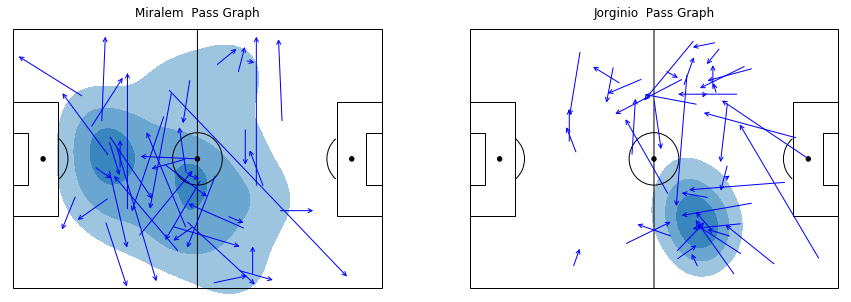

In [42]:
fig=plt.figure() #set up the figures
fig.set_size_inches(15, 5)
ax0=plt.subplot(1,2,1)
draw_pitch(ax0) #overlay our different objects on the pitch
sns.kdeplot([i[0]["x"]*1.2 for i in miralem_pass.positions], [i[0]["y"]*0.8 for i in miralem_pass.positions],
            n_levels=3,shade=True,shade_lowest=False)
for i in range(miralem_pass.shape[0]):
    ax0.annotate("", xy =(miralem_pass.loc[i,"pass_end"]["x"]*1.2,miralem_pass.loc[i,"pass_end"]["y"]*0.8),
                 xytext = (miralem_pass.loc[i,"pass_start"]["x"]*1.2,miralem_pass.loc[i,"pass_start"]["y"]*0.8), 
                 arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "blue"))
plt.title("Miralem  Pass Graph")
plt.ylim(-2, 82)
plt.xlim(-2, 122)
plt.axis('off')
ax1=plt.subplot(1,2,2)
draw_pitch(ax1) #overlay our different objects on the pitch
sns.kdeplot([i[0]["x"]*1.2 for i in jorgino_pass.positions], [i[0]["y"]*0.8 for i in jorgino_pass.positions],
            n_levels=3,shade=True,shade_lowest=False)
plt.title("Jorginio  Pass Graph")
for i in range(miralem_pass.shape[0]):
    ax1.annotate("", xy =(jorgino_pass.loc[i,"pass_start"]["x"]*1.2,jorgino_pass.loc[i,"pass_start"]["y"]*0.8),
                 xytext = (jorgino_pass.loc[i,"pass_end"]["x"]*1.2,jorgino_pass.loc[i,"pass_end"]["y"]*0.8), 
                 arrowprops=dict(arrowstyle="->",connectionstyle="arc3", color = "blue"))
plt.ylim(-2, 82)
plt.xlim(-2, 122)
plt.axis('off')